In [ ]:
import pandas as pd
import numpy as np
import optuna
# from optuna.samplers import CmaEsSampler
import matplotlib.pyplot as plt
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

TUNE_PARAMS = False

features_1 = [
    'Время',
    'pH оборотной воды',
    't оборотной воды',
    'Мощность МПСИ 1 кВт',
    'Мощность МШЦ 1 кВт',
    'Ток МПСИ 1 А',
    'Ток МШЦ 1 А',
    'Исходное питание МПСИ 1 т/ч',
    'Возврат руды МПСИ 1 т/ч',
    'Общее питание МПСИ 1 т/ч',
    'Расход воды МПСИ 1 PV м3/ч',
    'Расход воды МПСИ 1 SP м3/ч',
    'Расход воды МПСИ 1 CV %',
    'факт соотношение руда/вода МПСИ 1',
    'Давление на подшипник МПСИ 1 загрузка Бар',
    'Давление на подшипник МПСИ 1 разгрузка Бар',
    'Температура масла основной маслостанции подача МПСИ 1',
    'Температура масла основной маслостанции слив МПСИ 1',
    'Температура масла маслостанции электродвигатель МПСИ 1',
    'Температура масла редуктора МПСИ 1',
    'Давление на подшипник МШЦ 1 загрузка Бар',
    'Давление на подшипник МШЦ 1 разгрузка Бар',
    'Температура масла основной маслостанции подача МШЦ 1',
    'Температура масла основной маслостанции слив МШЦ 1',
    'Температура масла маслостанции электродвигатель МШЦ 1',
    'Температура масла редуктора МШЦ 1',
    'Расход извести МШЦ 1 л/ч',
    'Уровень в зумпфе 1 %',
    'Обороты насоса 1 1 %',
    'Давление в ГЦ насоса 1 1 Бар',
    'Плотность слива ГЦ 1 кг/л',
    'Поток 1 л/мин',
    'Гранулометрия 1 %',
    'Гранулометрия_1', # в сливе
    'Cu_1',
    'S_1',
    'Zn_1',
    'Переработка_руды_ВМТ_1',
    'Влажность_1',
    'Переработка_руды_СМТ_1',
]

df = pd.read_csv('good_dataset.csv', sep=',')
df_system1 = df[features_1].copy()
df_system1['Время'] = pd.to_datetime(df_system1['Время'])
df_system1 = df_system1.sort_values('Время')
df_system1.set_index('Время', inplace=True)
df_system1 = df_system1.fillna(method='ffill').fillna(method='bfill')

for col in df_system1.columns:
    df_system1[col] = df_system1[col].fillna(df_system1[col].median())

def create_lag_features(df, target_col, lags=range(1, 31)):
    df_copy = df.copy()

    for lag in lags:
        df_copy[f'{target_col}_lag_{lag}'] = df_copy[target_col].shift(lag)

    for window in [5, 10, 20]:
        df_copy[f'{target_col}_rolling_mean_{window}'] = df_copy[target_col].rolling(window=window).mean().shift(1)
        df_copy[f'{target_col}_rolling_std_{window}'] = df_copy[target_col].rolling(window=window).std().shift(1)

    df_copy[f'{target_col}_diff_1'] = df_copy[target_col].diff(1)
    df_copy[f'{target_col}_diff_2'] = df_copy[target_col].diff(2)

    df_copy = df_copy.dropna()

    return df_copy

target_col_1 = 'Гранулометрия 1 %'

df_system1_with_lags = create_lag_features(df_system1, target_col_1)

def time_based_split(df, train_ratio=0.8):
    df = df.sort_index()
    split_idx = int(len(df) * train_ratio)
    split_date = df.index[split_idx]
    train = df.loc[:split_date]
    test = df.loc[split_date:]

    return train, test

train_system1, test_system1 = time_based_split(df_system1_with_lags)

X_train_1 = train_system1.drop(target_col_1, axis=1)
y_train_1 = train_system1[target_col_1]
X_test_1 = test_system1.drop(target_col_1, axis=1)
y_test_1 = test_system1[target_col_1]

def obj(trial):
      params = {
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 5),
        'min_child_weight': trial.suggest_float('min_child_weight', 1e-3, 10),
        'objective': 'regression',
        'verbose': 0
    }
      model = LGBMRegressor(**params)
      model.fit(X_train_1, y_train_1)
      return mean_squared_error(y_test_1, model.predict(X_test_1))

if TUNE_PARAMS:
    # sampler = CmaEsSampler()
    study = optuna.create_study(direction='minimize')
    study.optimize(obj, n_trials=100, n_jobs=4)
    b_params = study.best_params
else:
    b_params = {
        'learning_rate': 0.243897132231155, 
        'n_estimators': 259, 
        'subsample': 0.9250000479229995, 
        'colsample_bytree': 0.7489947162633053, 
        'reg_alpha': 2.925654134327705, 
        'min_child_weight': 3.6364158669480187
    }

model_system1 = LGBMRegressor(**b_params)
model_system1.fit(X_train_1, y_train_1)

y_pred_1 = model_system1.predict(X_test_1)

def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")

    return mae, rmse, r2

metrics_system1 = evaluate_model(y_test_1, y_pred_1)

def predict_future(model, last_data, target_col, horizon=60):
    data = last_data.copy()
    feature_names = X_train_1.columns.tolist() if target_col == 'Гранулометрия 1 %' else X_train_2.columns.tolist()
    predictions = []

    for i in range(horizon):
        X = data[feature_names].iloc[-1:].values

        pred = model.predict(X)[0]
        predictions.append(pred)

        next_date = data.index[-1] + pd.Timedelta(minutes=1)
        new_row = pd.DataFrame(index=[next_date])

        for lag in range(1, 31):
            lag_feature = f"{target_col}_lag_{lag}"
            if lag_feature in feature_names:
                if lag == 1:
                    new_row[lag_feature] = pred
                else:
                    prev_lag = f"{target_col}_lag_{lag-1}"
                    if prev_lag in data.columns:
                        new_row[prev_lag] = data[prev_lag].iloc[-1]

        for window in [5, 10, 20]:
            mean_feature = f"{target_col}_rolling_mean_{window}"
            if mean_feature in feature_names:
                recent_values = list(data[target_col].iloc[-window+1:].values) + [pred]
                new_row[mean_feature] = np.mean(recent_values[-window:])

            std_feature = f"{target_col}_rolling_std_{window}"
            if std_feature in feature_names:
                recent_values = list(data[target_col].iloc[-window+1:].values) + [pred]
                if len(recent_values) >= 2:
                    new_row[std_feature] = np.std(recent_values[-window:])
                else:
                    new_row[std_feature] = 0

        diff_1_feature = f"{target_col}_diff_1"
        if diff_1_feature in feature_names:
            new_row[diff_1_feature] = pred - data[target_col].iloc[-1]

        diff_2_feature = f"{target_col}_diff_2"
        if diff_2_feature in feature_names:
            if len(data) >= 2:
                new_row[diff_2_feature] = pred - data[target_col].iloc[-2]
            else:
                new_row[diff_2_feature] = 0

        new_row[target_col] = pred

        for feature in feature_names:
            if feature not in new_row.columns and feature in data.columns:
                new_row[feature] = data[feature].iloc[-1]

        for feature in feature_names:
            if feature not in new_row.columns:
                new_row[feature] = 0

        data = pd.concat([data, new_row])

    return predictions

last_data_system1 = test_system1.iloc[-30:].copy()
future_preds_system1 = predict_future(model_system1, last_data_system1, target_col_1)

/tmp/ipykernel_13/1464206952.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_system1 = df_system1.fillna(method='ffill').fillna(method='bfill')


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.108623 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 18110
[LightGBM] [Info] Number of data points in the train set: 230984, number of used features: 76
[LightGBM] [Info] Start training from score 52.645799
MAE: 2.2949
RMSE: 3.6676
R2 Score: 0.9663


/usr/local/lib/python3.11/dist-packages/lightgbm/basic.py:722: UserWarning: Usage of np.ndarray subset (sliced data) is not recommended due to it will double the peak memory cost in LightGBM.
  _log_warning(


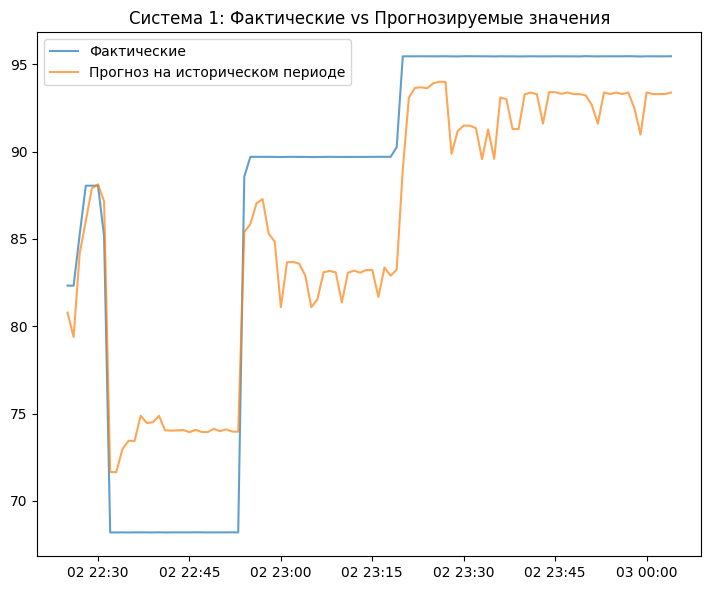

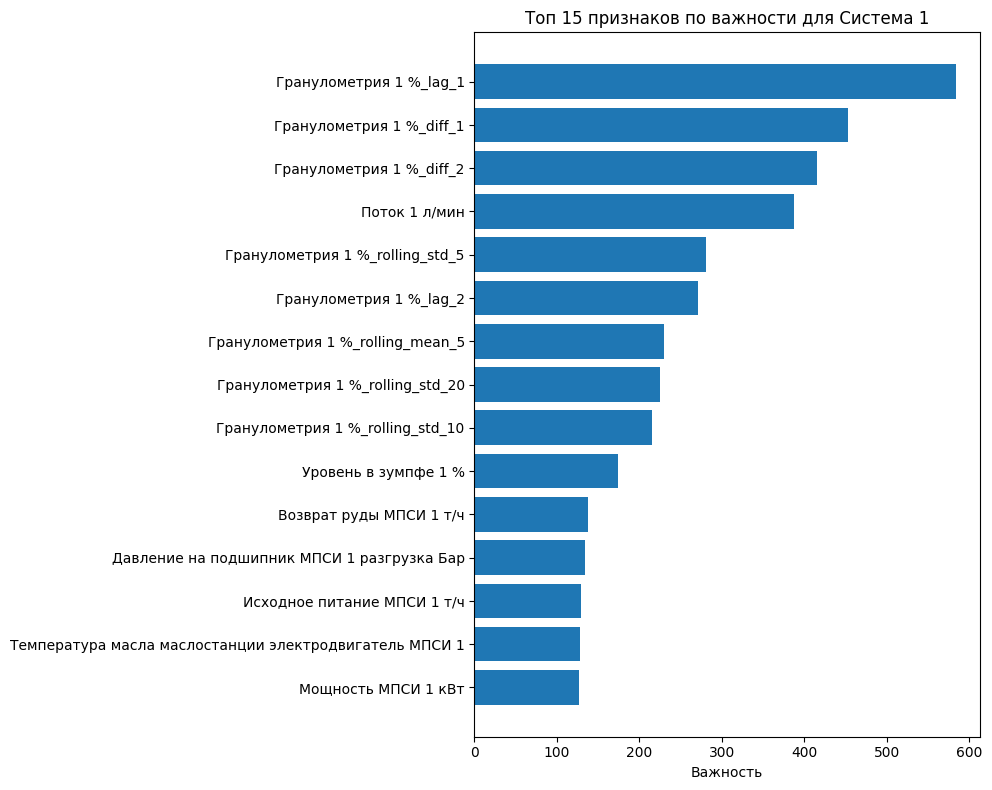


Топ-10 признаков для Системы 1:
                             Признак  Важность
38           Гранулометрия 1 %_lag_1       584
74          Гранулометрия 1 %_diff_1       453
75          Гранулометрия 1 %_diff_2       415
30                     Поток 1 л/мин       388
69   Гранулометрия 1 %_rolling_std_5       281
39           Гранулометрия 1 %_lag_2       271
68  Гранулометрия 1 %_rolling_mean_5       230
73  Гранулометрия 1 %_rolling_std_20       225
71  Гранулометрия 1 %_rolling_std_10       215
26              Уровень в зумпфе 1 %       174


In [2]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(y_test_1.index[-100:], y_test_1.values[-100:], label='Фактические', alpha=0.7)
plt.plot(y_test_1.index[-100:], y_pred_1[-100:], label='Прогноз на историческом периоде', alpha=0.7)
plt.title('Система 1: Фактические vs Прогнозируемые значения')
plt.legend()

plt.tight_layout()
plt.show()

def plot_feature_importance(model, feature_names, system_name, top_n=15):
    importance = model.feature_importances_
    indices = np.argsort(importance)[-top_n:]

    plt.figure(figsize=(10, 8))
    plt.barh(range(len(indices)), importance[indices])
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.title(f'Топ {top_n} признаков по важности для {system_name}')
    plt.xlabel('Важность')
    plt.tight_layout()
    plt.show()

    feature_importance = pd.DataFrame({
        'Признак': feature_names,
        'Важность': importance
    }).sort_values('Важность', ascending=False)

    return feature_importance

importance_system1 = plot_feature_importance(model_system1, X_train_1.columns.tolist(), 'Система 1')

print("\nТоп-10 признаков для Системы 1:")
print(importance_system1.head(10)) # здесь есть гранулометрия и это ок - мы предиктим будущее по прошлому и в прошлом гранулометрию мы знаем